# Exploración con redes neuronales

## Importación de librerías y configuración de entorno

In [1]:
#Importamos librerias necesarias para realizar el analisis. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos.
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Carga y preparación del dataset

In [2]:
df = pd.read_csv('../data/raw/diabetes_012_health_indicators_BRFSS2015.csv')

y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

num_classes = len(np.unique(y_train))

## Conversión a tensores y creación de datasets

In [3]:
# TRAIN
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# VALIDATION
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# TEST
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# DATASETS
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Sampler balanceado y DataLoaders

In [ ]:
# ===== ESTRATEGIA A =====
# Solo WeightedRandomSampler

class_counts = y_train.value_counts().sort_index().values
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train.values.astype(int)]

# Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

In [4]:
# ===== ESTRATEGIA B =====
# Solo weighted loss

class_counts = y_train.value_counts().sort_index().values
N = len(y_train)

class_weights = torch.tensor(N / (num_classes * class_counts), dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

## Definición del modelo MLP

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.2):
        super(Net, self).__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]
output_dim = num_classes

model = Net(input_dim, hidden_dims, output_dim).to(device)

## Función de pérdida y optimizador

In [6]:
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

## Funciones de entrenamiento y evaluación

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += Xb.size(0)

    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

## Entrenamiento del modelo y cálculo de métricas clave

In [8]:
epochs = 20
best_macro_f1 = -np.inf

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    y_true, y_pred = evaluate(model, val_loader, device)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    if f1 > best_macro_f1:
        best_macro_f1 = f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        print(">> Nuevo mejor modelo (macro F1).")

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 0.9971 | Train Acc: 0.6337 | Test Acc: 0.6397 | Precision: 0.4162 | Recall: 0.4913 | F1: 0.3923
>> Nuevo mejor modelo (macro F1).
Epoch 02 | Train Loss: 0.9632 | Train Acc: 0.6776 | Test Acc: 0.7077 | Precision: 0.4505 | Recall: 0.4947 | F1: 0.4156
>> Nuevo mejor modelo (macro F1).
Epoch 03 | Train Loss: 0.9579 | Train Acc: 0.6898 | Test Acc: 0.7189 | Precision: 0.4139 | Recall: 0.4942 | F1: 0.4180
>> Nuevo mejor modelo (macro F1).
Epoch 04 | Train Loss: 0.9525 | Train Acc: 0.6916 | Test Acc: 0.6940 | Precision: 0.4252 | Recall: 0.4977 | F1: 0.4101
Epoch 05 | Train Loss: 0.9522 | Train Acc: 0.6877 | Test Acc: 0.6840 | Precision: 0.4211 | Recall: 0.4994 | F1: 0.4116
Epoch 06 | Train Loss: 0.9493 | Train Acc: 0.6944 | Test Acc: 0.7057 | Precision: 0.4238 | Recall: 0.5000 | F1: 0.4201
>> Nuevo mejor modelo (macro F1).
Epoch 07 | Train Loss: 0.9490 | Train Acc: 0.6897 | Test Acc: 0.6570 | Precision: 0.4189 | Recall: 0.4969 | F1: 0.3944
Epoch 08 | Train Loss: 0.9481 |

<All keys matched successfully>

## Evaluación final del modelo

              precision    recall  f1-score   support

           0     0.9354    0.7571    0.8369     42741
           1     0.0402    0.0432    0.0416       926
           2     0.3337    0.7150    0.4550      7069

    accuracy                         0.7382     50736
   macro avg     0.4364    0.5051    0.4445     50736
weighted avg     0.8353    0.7382    0.7692     50736



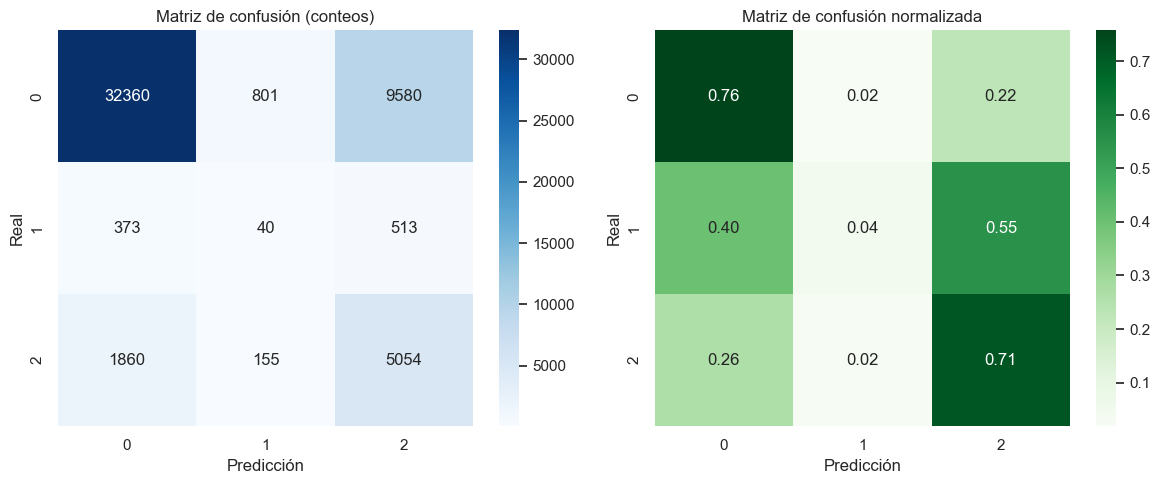

Macro F1: 0.4445 | Weighted F1: 0.7692


In [ ]:
y_true, y_pred = evaluate(model, test_loader, device)

print(classification_report(y_true, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=axes[0])
axes[0].set_title("Matriz de confusión (conteos)")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=axes[1])
axes[1].set_title("Matriz de confusión normalizada")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()